### 02 - Análisis de consumo (consumo_filtrado)

Notebook exploratorio sobre el dataset filtrado (`consumo_filtrado.csv`): consumo de MP, scrap y capacidad por referencia/máquina.


#### Imports y opciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
plt.style.use("seaborn-v0_8")


#### Carga del dataset filtrado

In [2]:
PATH = "../../data/proccessed/consumo_filtrado.csv"

df = pd.read_csv(PATH, dtype=str)

# Parseo de fechas
for c in ["ts_ini","ts_fin","fecha","fecha_recepcion_ts"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Conversión numérica
num_cols = [
    "piezas_ok","piezas_scrap","qty_plan","qty_estimado","qty_in_almacen_dia",
    "horas_teoricas","reduccion_tco","horas_ajustadas","horas_enfermedad",
    "horas_accidente","horas_permiso","horas_netas","qty_recibida",
    "peso_bruto","uds","throughput_uph","scrap_rate","duracion_min",
    "downtime_min","consumo_materia_kg","lead_time_al_almacen_dias","peso_neto_kg",
    "flag_sin_peso","flag_con_peso"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Normaliza referencias
if "ref_id_str" in df.columns:
    df["ref_id_str"] = (df["ref_id_str"].astype(str)
                           .str.replace(r"\.0$", "", regex=True)
                           .str.zfill(6))

print("Filas, columnas:", df.shape)
df.head(3)


Filas, columnas: (30948, 40)


,work_order_id,op_id,machine_id,machine_name,planta,op_text,ref_id_str,familia,peso_neto_kg,material_lot_id,ref_materia_str,ts_ini,ts_fin,fecha,duracion_min,evento,tipo_incidencia,piezas_ok,piezas_scrap,qty_plan,qty_estimado,qty_in_almacen_dia,año_mes,horas_teoricas,reduccion_tco,horas_ajustadas,horas_enfermedad,horas_accidente,horas_permiso,horas_netas,qty_recibida,peso_bruto,uds,fecha_recepcion_ts,throughput_uph,scrap_rate,downtime_min,consumo_materia_kg,flag_sin_peso,flag_con_peso
0,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 00:50:00,2025-01-28 01:39:00,2025-01-28,49.0,Preparación,NaN,0,0,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,0.000000,NaN,0.0,0.0,0,1
1,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 05:17:00,2025-01-28 05:49:00,2025-01-28,32.0,Incidencia,AUSENCIA,0,0,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,0.000000,NaN,32.0,0.0,0,1
2,24/0767,TALLADO,49,Talladora49,Abadiño,TALLADO,000305,CORONA DE ARRANQUE,5.0,NaN,NaN,2025-01-28 01:39:00,2025-01-28 06:29:00,2025-01-28,290.0,Producción,NaN,105,3,0.0,592.0,NaN,2025-01,12350.0,788.0,11562.0,752.0,0.0,390.0,10420.0,NaN,NaN,NaN,NaT,21.724138,0.027778,0.0,525.0,0,1


#### Resumen y nulos

In [3]:
# Nulos por columna (top 10)
nulls = df.isna().sum().sort_values(ascending=False)
total = len(df)
nulls_df = (
    pd.DataFrame({"nulos": nulls, "total_filas": total})
      .assign(pct=lambda d: (d["nulos"]/d["total_filas"]) * 100)
      .sort_values("nulos", ascending=False)
)
nulls_df.head(10)


,nulos,total_filas,pct
scrap_rate,20302,30948,65.600362
qty_in_almacen_dia,17494,30948,56.527078
tipo_incidencia,11945,30948,38.597001
ref_materia_str,6216,30948,20.085304
material_lot_id,6216,30948,20.085304
qty_recibida,6216,30948,20.085304
uds,6216,30948,20.085304
peso_bruto,6216,30948,20.085304
fecha_recepcion_ts,6216,30948,20.085304
throughput_uph,499,30948,1.612382


#### Agregados por referencia

In [4]:
ref_agg = (
    df.groupby("ref_id_str", dropna=False)
      .agg(
          piezas_ok_totales=("piezas_ok","sum"),
          piezas_scrap_totales=("piezas_scrap","sum"),
          consumo_materia_kg_total=("consumo_materia_kg","sum"),
          peso_neto_kg_media=("peso_neto_kg","mean"),
          scrap_rate_medio=("scrap_rate","mean"),
          throughput_uph_medio=("throughput_uph","mean"),
      )
      .reset_index()
)

ref_agg["yield_kg_ok"] = ref_agg["piezas_ok_totales"] * ref_agg["peso_neto_kg_media"]
ref_agg["kg_scrap_estimados"] = ref_agg["consumo_materia_kg_total"] - ref_agg["yield_kg_ok"]
ref_agg["ratio_mp_por_1000_ok"] = np.where(
    (ref_agg["piezas_ok_totales"]>0) & (ref_agg["consumo_materia_kg_total"]>0),
    ref_agg["consumo_materia_kg_total"] / (ref_agg["piezas_ok_totales"] / 1000),
    np.nan
)
ref_agg["peso_positivo"] = ref_agg["peso_neto_kg_media"] > 0

ref_agg.sort_values("consumo_materia_kg_total", ascending=False).head(10)


,ref_id_str,piezas_ok_totales,piezas_scrap_totales,consumo_materia_kg_total,peso_neto_kg_media,scrap_rate_medio,throughput_uph_medio,yield_kg_ok,kg_scrap_estimados,ratio_mp_por_1000_ok,peso_positivo
0,000305,674852,547,3374260.00,5.00,0.041888,198.002387,3374260.00,0.000000e+00,5000.0,True
32,473205,608250,535,3126405.00,5.14,0.047713,770.718554,3126405.00,0.000000e+00,5140.0,True
13,081000,1794108,1236,2852631.72,1.59,0.008730,923.204754,2852631.72,0.000000e+00,1590.0,True
46,936205,523009,671,1464425.20,2.80,0.047718,650.685140,1464425.20,0.000000e+00,2800.0,True
47,936305,483990,484,1432610.40,2.96,0.041304,180.207614,1432610.40,0.000000e+00,2960.0,True
40,902081,1381366,1779,1395179.66,1.01,0.025736,163.080171,1395179.66,0.000000e+00,1010.0,True
20,081901,1214710,1003,1081091.90,0.89,0.015484,295.898823,1081091.90,-2.328306e-10,890.0,True
22,086503,1191777,633,977257.14,0.82,0.018439,279.711128,977257.14,-1.164153e-10,820.0,True
33,510086,325931,357,880013.70,2.70,0.058031,419.190875,880013.70,0.000000e+00,2700.0,True
16,081303,1235060,1314,802789.00,0.65,0.022599,434.333183,802789.00,0.000000e+00,650.0,True


/tmp/ipykernel_56539/3842757625.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(ref_top_consumo["ref_id_str"], rotation=45, ha='right')
/tmp/ipykernel_56539/3842757625.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(ref_top_scrap["ref_id_str"], rotation=45, ha='right')


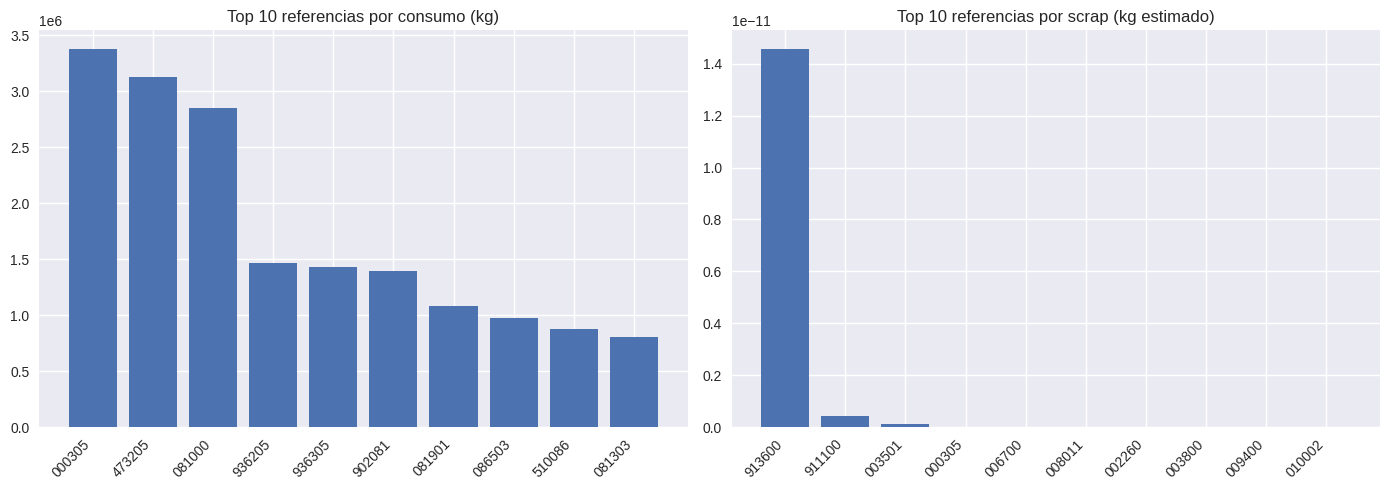

In [5]:
# Top referencias por consumo y scrap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ref_top_consumo = ref_agg.sort_values("consumo_materia_kg_total", ascending=False).head(10)
axes[0].bar(ref_top_consumo["ref_id_str"], ref_top_consumo["consumo_materia_kg_total"])
axes[0].set_title("Top 10 referencias por consumo (kg)")
axes[0].set_xticklabels(ref_top_consumo["ref_id_str"], rotation=45, ha='right')

ref_top_scrap = ref_agg.sort_values("kg_scrap_estimados", ascending=False).head(10)
axes[1].bar(ref_top_scrap["ref_id_str"], ref_top_scrap["kg_scrap_estimados"])
axes[1].set_title("Top 10 referencias por scrap (kg estimado)")
axes[1].set_xticklabels(ref_top_scrap["ref_id_str"], rotation=45, ha='right')

plt.tight_layout()
plt.show()


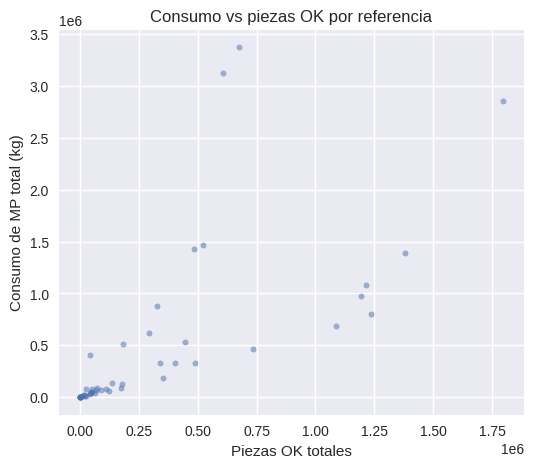

In [6]:
# Dispersión piezas OK vs consumo
plt.figure(figsize=(6,5))
plt.scatter(ref_agg["piezas_ok_totales"], ref_agg["consumo_materia_kg_total"], alpha=0.5, s=15)
plt.xlabel("Piezas OK totales")
plt.ylabel("Consumo de MP total (kg)")
plt.title("Consumo vs piezas OK por referencia")
plt.show()


#### Por máquina y referencia

In [7]:
ref_machine = (
    df.groupby(["ref_id_str","machine_id","machine_name"], dropna=False)
      .agg(
          throughput_uph_medio=("throughput_uph","mean"),
          scrap_rate_medio=("scrap_rate","mean"),
          duracion_min_media=("duracion_min","mean"),
          piezas_ok_por_evento=("piezas_ok","mean"),
      )
      .reset_index()
)

if "lead_time_al_almacen_dias" in df.columns:
    lead = (
        df.groupby(["ref_id_str","machine_id","machine_name"], dropna=False)
          .agg(lead_time_dias_medio=("lead_time_al_almacen_dias","mean"))
          .reset_index()
    )
    ref_machine = ref_machine.merge(lead, on=["ref_id_str","machine_id","machine_name"], how="left")

ref_machine.sort_values("throughput_uph_medio", ascending=False).head(10)


,ref_id_str,machine_id,machine_name,throughput_uph_medio,scrap_rate_medio,duracion_min_media,piezas_ok_por_evento
345,563404,505,SOLDADORA,109840.909091,0.250000,14.500000,993.375000
420,911100,27,Prensa27,58144.827586,0.000000,15.000000,1223.333333
153,081505,542,Soldadora Ideal DD0101,31372.454573,0.000043,108.000000,3021.800000
301,473205,118,Horno,14820.657644,0.000000,200.125000,2985.075000
380,902081,118,Horno,14542.853020,0.000000,135.000000,3757.833333
431,913600,542,Soldadora Ideal DD0101,13521.595818,0.000341,83.545455,2023.090909
145,081303,517,Granalladora Sthick,11556.779775,0.000000,210.256410,3785.076923
454,936205,110,Granalladora,11304.443824,0.000373,73.884615,2759.461538
441,936105,118,Horno,11041.193086,0.000000,185.416667,2886.666667
314,510086,118,Horno,9964.534041,0.000000,191.250000,3510.000000


#### Distribuciones básicas

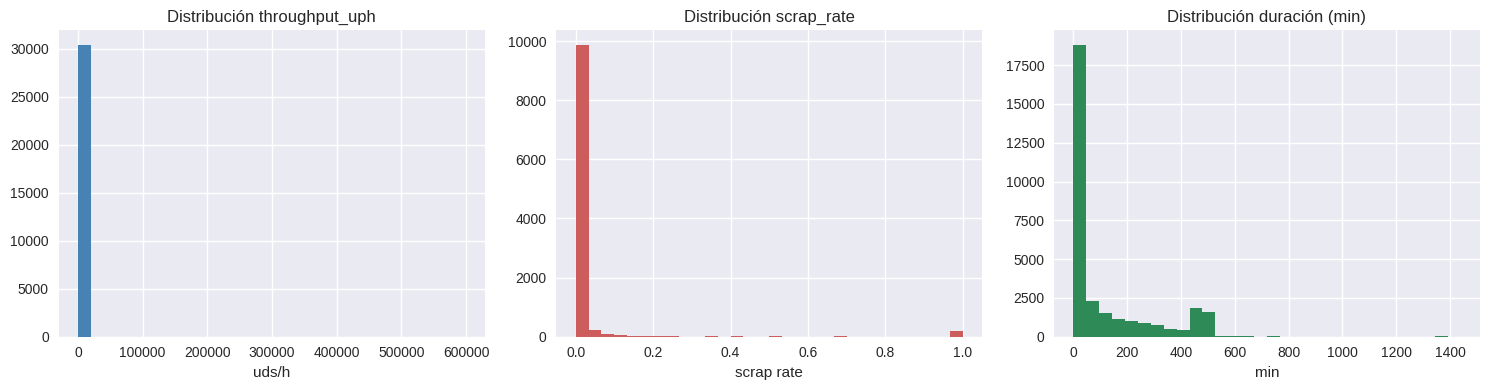

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["throughput_uph"].dropna(), bins=30, color='steelblue')
axes[0].set_title("Distribución throughput_uph")
axes[0].set_xlabel("uds/h")

axes[1].hist(df["scrap_rate"].dropna(), bins=30, color='indianred')
axes[1].set_title("Distribución scrap_rate")
axes[1].set_xlabel("scrap rate")

axes[2].hist(df["duracion_min"].dropna(), bins=30, color='seagreen')
axes[2].set_title("Distribución duración (min)")
axes[2].set_xlabel("min")

plt.tight_layout()
plt.show()


#### Export de resumen por referencia

In [9]:
# Guardar resumen por referencia para uso rápido
OUTPUT_REF = "../../data/proccessed/consumo_ref_summary.csv"
ref_agg.to_csv(OUTPUT_REF, index=False)
print("Guardado:", OUTPUT_REF)
ref_agg.head(3)


Guardado: ../../data/proccessed/consumo_ref_summary.csv


,ref_id_str,piezas_ok_totales,piezas_scrap_totales,consumo_materia_kg_total,peso_neto_kg_media,scrap_rate_medio,throughput_uph_medio,yield_kg_ok,kg_scrap_estimados,ratio_mp_por_1000_ok,peso_positivo
0,000305,674852,547,3374260.000,5.000,0.041888,198.002387,3374260.000,0.000000e+00,5000.0,True
1,002260,86,0,84.538,0.983,0.000000,452.910448,84.538,0.000000e+00,983.0,True
2,003501,868,31,824.600,0.950,0.050880,9.436678,824.600,1.136868e-13,950.0,True
